In [16]:
import numpy as np
from numpy.linalg import norm
from numpy.random import randn
from math import atan2

class RadarStation:
    def __init__(self, pos, range_std, elev_angle_std):
        self.pos = np.asarray(pos)
        self.range_std = range_std
        self.elev_angle_std = elev_angle_std
    
    def reading_of(self, ac_pos):
        diff = np.subtract(ac_pos, self.pos)
        rng = norm(diff)
        brg = atan2(diff[1], diff[0])
        return rng, brg

    def noisy_reading(self, ac_pos):

        rng, brg = self.reading_of(ac_pos)
        rng += randn() * self.range_std
        brg += randn() * self.elev_angle_std
        return rng, brg
    
class ACSim:
    def __init__(self, pos, vel, vel_std):
        self.pos = np.asarray(pos, dtype=float)
        self.vel = np.asarray(vel, dtype=float)
        self.vel_std = vel_std
    def update(self, dt):
        dx = self.vel*dt + (randn() * self.vel_std) * dt
        self.pos += dx
        return self.pos

In [19]:
import matplotlib.pyplot as plt

def plot_altitude(xs, t, track):
    xs = np.asarray(xs)

    plt.plot(t, xs[:,2], label='filter', )
    plt.plot(t, track, label='Aircraft', lw=2, ls='--', c='k')
    plt.xlabel('time(sec)')
    plt.ylabel('altitude')
    plt.legend(loc=4)

Actual altitude: 2515.6
UKF altitude : 2500.1


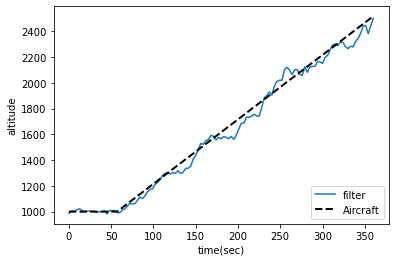

In [20]:
import math
import numpy as np
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints, UKF
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import UnscentedKalmanFilter as UKF
from numpy.random import randn


dt = 3.
ac_pos = (0., 1000.)
range_std = 5
elevation_angle_std = math.radians(0.5)
pos = (0, 0)
radar = RadarStation(pos, range_std, elevation_angle_std)


def h_radar(x):

    dx = x[0] - h_radar.radar_pos[0]
    dy = x[2] - h_radar.radar_pos[1]
    slant_range = math.sqrt(dx**2 + dy**2)
    elevation_angle = math.atan2(dy, dx)
    return [slant_range, elevation_angle]

h_radar.radar_pos = (0, 0)

def f_cv_radar(x, dt):

    F = np.array([[1, dt, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, dt],
                  [0, 0, 0, 1]], dtype=float)

    return np.dot(F, x)

def cv_UKF(fx, hx, R_std):
    points = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=-1.)
    kf = UKF(4, len(R_std), dt, fx=fx, hx=hx, points=points)
    kf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
    kf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=dt, var=0.1)
    kf.R = np.diag(R_std)
    kf.R = np.dot(kf.R, kf.R) # square to get variance
    kf.x = np.array([0., 90., 1100., 0.])
    kf.P = np.diag([300**2, 3**2, 150**2, 3**2])
    return kf

np.random.seed(200)
ac = ACSim(ac_pos, (100, 0), 0.02)

kf_cv = cv_UKF(f_cv_radar, h_radar, R_std=[range_std, elevation_angle_std])
time = np.arange(0, 360 + dt, dt)
xs, ys = [], []
for t in time:
    if t >= 60:
        ac.vel[1] = 300/60 # 300 meters/minute climb
    ac.update(dt)
    r = radar.noisy_reading(ac.pos)
    ys.append(ac.pos[1])
    kf_cv.predict()
    kf_cv.update([r[0], r[1]])
    xs.append(kf_cv.x)
    
plot_altitude(xs, time, ys)
print('Actual altitude: {:.1f}'.format(ac.pos[1]))
print('UKF altitude : {:.1f}'.format(xs[-1][2]))